## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from scipy.stats import norm
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

The dataset has 294,478 rows (and 5 columns).

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

The dataset contains 290,584 unique users.

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

11.97% of users converted.

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query('group == "treatment"').query('landing_page == "old_page"')['user_id'].count() \
+ df.query('group == "control"').query('landing_page == "new_page"')['user_id'].count()

3893

``new_page`` and ``treatment`` don't line up 3,893 times.

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


All 5 columns contain exactly 294,478 non-null values. Thus there are no missing values.

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
#query rows where the alignment is not True
not_aligned1 = df.query('group == "treatment"').query('landing_page == "old_page"')
not_aligned2 = df.query('group == "control"').query('landing_page == "new_page"')

#create new DataFrame df2 where those rows are dropped.
df2 = df.drop(not_aligned1.index)
df2 = df2.drop(not_aligned2.index)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

There are 290,584 unique users in df2.

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
# check if there is indeed one repeated user_id
df2.duplicated(subset='user_id').sum()

1

In [12]:
# check which user_id is repeated
df2[df2.duplicated(subset='user_id', keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


The ``user_id`` 773192 is repeated.

c. What is the row information for the repeat **user_id**? 

As seen in the previous output, the row information is ``index 2893``, ``group treatment``, ``landing_page new_page`` and ``converted 0``.

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop(2893, axis=0)
# check if worked
df2.duplicated(subset='user_id').sum()

0

df2 now contains no more duplicates.

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.mean()

0.11959708724499628

The probability of an individual to convert is 11.96%.

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
# probability of group = control and converted divided by probability of group = control
p_control_conv = df2.query('group == "control"')['converted'].mean()
p_control_conv

0.1203863045004612

Given than an individual was in the ``control`` group, the probability they converted is 12.04%

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
p_treatment_conv = df2.query('group == "treatment"')['converted'].mean()
p_treatment_conv

0.11880806551510564

Given that an individual was in the ``treatment`` group, the probability they converted is 11.88%.

d. What is the probability that an individual received the new page?

In [17]:
df2.query('landing_page == "new_page"')['user_id'].count() / df2.user_id.count()

0.5000619442226688

The probability that an individual received the new page is 50%. Thus, we need not worry about imbalances between groups.

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

No, there is not sufficient evidence to suggest that the new treatment page leads to more conversions. The conversion rate is roughly the same for both control groups and thus gives no significant reason to believe that the new treatment page is superior to the old landing page.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} - p_{old} \leq 0$$

$$H_1: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
cr_new = df2.converted.mean()
cr_new

0.11959708724499628

Since $p_{new}$ and $p_{old}$ are supposed to be equal, both account for a value of 11.96%.

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
cr_old = df2.converted.mean()
cr_old

0.11959708724499628

c. What is $n_{new}$?

In [20]:
n_new = df2.query('group == "treatment"').count()[1]
n_new

145310

The value for $n_{new}$ is 145,310.

d. What is $n_{old}$?

In [21]:
n_old = df2.query('group == "control"').count()[1]
n_old

145274

The value for $n_{new}$ is 145,274.

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.choice([0, 1], n_new, p=[(1 - cr_new), cr_new])
new_page_converted

array([0, 0, 1, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice([0, 1], n_old, p=[(1 - cr_old), cr_old])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
diff = new_page_converted.mean() - old_page_converted.mean()
diff

0.0015049390692078446

The difference in $p_{new}$ - $p_{old}$ is 0%.

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
p_diffs = []
for i in range(10000):
    new_page_converted1 = np.random.choice([0, 1], n_new, p=[(1 - cr_new), cr_new])
    old_page_converted1 = np.random.choice([0, 1], n_old, p=[(1 - cr_old), cr_old])
    p_diffs.append(new_page_converted1.mean() - old_page_converted1.mean())
    
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

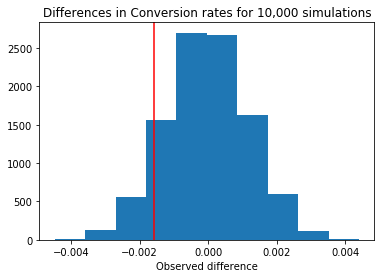

In [26]:
plt.hist(p_diffs)
plt.axvline((p_treatment_conv - p_control_conv), c='r')
plt.title('Differences in Conversion rates for 10,000 simulations')
plt.xlabel('Observed difference');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
(p_diffs > (p_treatment_conv - p_control_conv)).mean()

0.9008

A proportion of 90.08% is greater than the actual difference observed in ab_data.csv.

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The p-value was computed in part j. The p-value is the probability of observing the statistic (or one more extreme in favor of the alternative) if the null hypothesis is true. The Type I error threshold was set to be $\alpha$ = 0.05. The computed p-value of 0.9008 is not lower that 0.05 which means we fail to reject the null hypothesis. As a result, there is no statistical evidence for a higher conversion rate for the new langing page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
convert_old = df.query('group == "control"').query('converted == True').count()[1]
convert_new = df.query('group == "treatment"').query('converted == True').count()[1]
n_old = df.query('group == "control"').count()[1]
n_new = df.query('group == "treatment"').count()[1]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [29]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.2369217547321678, 0.8919419336512124)

In [30]:
norm.ppf(0.95)

1.6448536269514722

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The critical value for the null hypothesis is 1.64. This means that for x > 1.64, the null hypothesis can be receted. For every value between -$\infty$ and 1.64, we fail to reject the null hypothesis. The z-score computed with the ``proportions_ztest`` is -1.24 which means that we fail to reject the null hypothesis. The p-value is similar to the one computed in j.

Conclusion: the results computed via the ``proportions_ztest`` method align with the previous bootstrapped sample method.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**logistic regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
# create intercept
df2['intercept'] = 1

# get dummies and add ab_page column
df2[['control', 'treatment']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


In [32]:
df2.drop('control', axis=1, inplace=True)
df2 = df2.rename(columns={'treatment': 'ab_page'})
df2.head(1)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [33]:
logistm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = logistm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [34]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 12 Dec 2018   Pseudo R-squ.:               8.077e-06
Time:                        22:02:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [35]:
1 - np.exp(-0.0150)

0.014888060396937353

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value for ab_page is 0.190. The hypothesis for the logistic regression is whether the ab_page variable has an influence on the converted variable.

($H_{0}$: ab_page variable has no influence on the converted variable, $H_{1}$: ab_page has an influence on the converted variable. Thus a two tailed test was used for the regression approach.

Part II tested if one value of the ab_page variable (treatment) had a higher conversion rate than the other (control). Here, a one sided t-test was used.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Adding additional factors to the regression model can aid in getting a better insight to what drives the conversion rate but also increases the risk for multicollinearity among variables. When variables are correlated among each other, the reliability of the results decrease. The variance inflation factors can be calculated to check for a possible correlation among the variables and drop any if necessary.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [36]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [37]:
df_new.head(2)

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1


In [38]:
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

The country column contains the 3 values UK, US and CA.

In [39]:
# get country dummies
country_dummies = pd.get_dummies(df_new['country'])
df_new = df_new.join(country_dummies)
df_new.head(2)

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1


In [40]:
# logistic regression on country influence, base=US
logistm2 = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])
result2 = logistm2.fit()
result2.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 12 Dec 2018   Pseudo R-squ.:               1.521e-05
Time:                        22:02:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

In [41]:
# just for the fun of it calculating the practical implications if p-value were significant
1 / np.exp(-0.0408)

1.0416437559600236

In [42]:
np.exp(0.0099)

1.0099491671175422

The p-value for both country variables is not significant (0.129 and 0.456 are higher than the $\alpha$ threshold of 0.05). 

(However, if it were significant, the the conversion rate of an individual living in the US would be 1.041 times more likely to convert than an individual living in Canda, holding all other variables constant. An individual living in the UK would be 1.01 times more likely to convert than an individual living in the US, holding all other variables constant.)

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [43]:
df_new['CA_page'] = df_new['ab_page'] * df_new['CA']
df_new['UK_page'] = df_new['ab_page'] * df_new['UK']
df_new.head(2)

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,CA_page,UK_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0


In [44]:
logistm3 = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK', 'ab_page', 'CA_page', 'UK_page']])
results3 = logistm3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 12 Dec 2018   Pseudo R-squ.:               3.482e-05
Time:                        22:02:16   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_page        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

None of the variables has a p-value lower than 0.05 which means that we fail to reject the null hypothesis for an $\alpha$ of 0.05. As a conclusion, we have **no** statistical evidence that the new landing page is superior in either of the evaluated variables compared to the old landing page. 


Now just a quick check if the logistic regression model is biased by multicollinearity among the variables. To evaluate the level collinearity among the variables, the variance inflation factors are calculated. A description on how to calculate VIF can be found [here](https://etav.github.io/python/vif_factor_python.html).

In [45]:
y, X = dmatrices('converted ~ CA + UK + ab_page + CA_page + UK_page', df_new, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

vif

,VIF Factor,features
0,2.856817,Intercept
1,2.049235,CA
2,2.030763,UK
3,1.427098,ab_page
4,2.103521,CA_page
5,2.366531,UK_page


As a rule of thumb, if the VIF are less than 10, then we do not have to worry about multicollinearity in the model. Here, clearly all VIF are way less than 10 which means that the regression model is unlikely to be biased by collinearity among variables.

As a bonus, let's explore some limitations of the dataset and testing procedure.

In [46]:
df_new.timestamp.min()

'2017-01-02 13:42:05.378582'

In [47]:
df_new.timestamp.max()

'2017-01-24 13:41:54.460509'

The experiment was run over a course of 23 days. This is not a very long time frame and can possibly lead to biased results due to psychological factors such as change aversion and novelty effect. Change aversion means that existing users give an unfair advantage to the old landing page simply because they're unhappy with change and don't want to adjust or need more time to adjust to the new page. The novelty effect states that new users give an unfair advantage to the new page, simply because it's exciting and new and not necessarily because it's superior to the old page. However, for those effects to hold true, it would need to be assumed that users were familiar with the web page prior to the test.

Now, let's analyse the conversion rate for different time periods so see if we can find a difference here.

In [48]:
# change timestamp column from string to datetime object
df_new['timestamp'] = pd.to_datetime(df_new['timestamp'])

In [49]:
# create new column day_of_month which contains the day of the timestamp
df_new['day_of_month'] = df_new['timestamp'].dt.day

Now we've got a column called ``day_of_month`` which exctracted the day from the timestamp column. In order to compare if the conversion rate differs for different aspects of time, I'm going to group the values in the ``day_of_week`` column into 4 equally large sections where each section is going to be a period of 6 days. (Side note: this is not entirely true as the experiment is run over a period of 23 days which is an odd number. Therefore the first three periods are 6 days long while the fourth period is only five days long.)

In [50]:
# define function which queries the day_of_month column
def assign_week(df_new):
    if df_new['day_of_month'] <= 7:
        week = 1
    elif df_new['day_of_month'] <= 13:
        week = 2
    elif df_new['day_of_month'] <= 19:
        week = 3
    else : week = 4
    return week

In [51]:
# create a new colum period
df_new['period'] = df_new.apply(assign_week, axis=1)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,CA_page,UK_page,day_of_month,period
user_id,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,14,3
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0,23,4
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1,16,3
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,22,4
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1,16,3


In [52]:
# get dummies from period column to use in regression
df_new[['period1', 'period2', 'period3', 'period4']] = pd.get_dummies(df_new['period'])
df_new.head(2)

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,CA_page,UK_page,day_of_month,period,period1,period2,period3,period4
user_id,,,,,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,14,3,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0,23,4,0,0,0,1


Now we finally got our dummy variables for different time periods to use in the regression model.

In [53]:
# apply logistic regression and use period1 as base
logistm4 = sm.Logit(df_new['converted'], df_new[['intercept', 'period2', 'period3', 'period4']])
result4 = logistm4.fit()
result4.summary()

Optimization terminated successfully.
         Current function value: 0.366114
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 12 Dec 2018   Pseudo R-squ.:               2.065e-05
Time:                        22:02:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.2220
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0075      0.012   -173.485      0.000      -2.030      -1.985
period2        0.0018      0.016      0.113      0.910      -0.029       0.033
period3        0.0291      0.016      1.829      0.067      -0.002       0.060
period4        0.0136      0.017      0.799      0.424      -0.020       0.047
==============================================================================
"""

None of the p-values is significant for $\alpha$ = 0.05 which means that we cannot prove that the conversion rate differs for different time periods. 

### Resources

[How to use VIF](http://knowledgetack.com/python/statsmodels/proportions_ztest/)